<a href="https://colab.research.google.com/github/Vest1ge/ML_Project/blob/main/2017250024_ML_Project6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> 학번 : 2017250024
>
> 이름 : 오재영

# 기본설정

In [35]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 문제 1

랜덤 포레스트를 직접 구현한 다음에 사이킷런의 랜덤 포레스트 모델을 사용하는 것과의 성능을 비교하라.

## 데이터 준비

사이킷럿에서 제공하는 데이터셋을 불러왔다.

`make_moons`   함수는 인공적으로 초승달 모양 클러스터 두 개 형상의 데이터를 생성한다.


* `n_samples` : 표본 데이터의 수
* `noise` : 잡음의 크기, 0이면 정확한 반원을 이룸
* `random_state` : 결과를 일정하게 하기 위해 사용

반환값:

* X : [`n_samples`, `n_features`] 크기의 배열, `n_features`의 기본값은 20

* y : [`n_samples`] 크기의 배열

In [36]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

데이터를 보여주는 그래프이다. 표본 샘플 수가 많아서 빽빽하게 나온다.

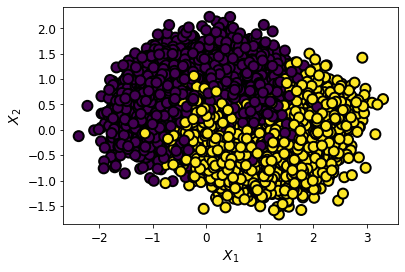

In [37]:
# 데이터를 보여주는 그래프 생성
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=100,
            edgecolor="k", linewidth=2)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.show()

## 데이터 분할

사이킷런의 `train_test_split()`을 사용해 훈련 세트와 테스트 세트로 나눈다.

8 : 2 의 비율로 훈련 세트와 테스트 세트를 구분한다.
앞에서 생성한 데이터 `X`와 `y`를 인자로 사용한다.

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 결정 트리 회귀 훈련

랜덤 포레스트 분류기는 결정 트리들을 사용하기 때문에 먼저 결정 트리 회귀 훈련을 이용한다.

`DecisionTreeClassifier` (결정트리) 과정에서 최적의 매개 변수를 찾기 위해 `GridSearchCV`를 사용하여 교차 검증과 함께 그리드 탐색을 수행한다.

* `params`
 * `max_leaf_nodes` : 생성될 말단(리프) 노드의 최대 수 제한
 * `min_samples_split` : 자식 노드를 분할하는데 필요한 최소 샘플 데이터 수

* `verbose = 1` : 간단한 메시지 출력
* `cv` : 폴드 수, 아래 코드는 3개의 폴드 사용

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 882 out of 882 | elapsed:    9.6s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,


`max_leaf_nodes = 17`가 최적의 값으로 나왔다.




In [40]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=17,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

### 정확도 측정

찾은 매개변수를 사용해 전체 훈련 세트에 대해 모델을 훈련시키고 테스트 세트에서 성능을 측정한다.

기본적으로 `GridSearchCV`는 전체 훈련 세트로 찾은 최적의 모델을 다시 훈련시킨다.

In [41]:
from sklearn.metrics import accuracy_score

y_pred = grid_search_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.8695

정확도가 대략 87% 이다.

## 서브셋 생성

사이킷런의 `ShuffleSplit`을 사용하여 훈련 세트의 서브셋을 1,000개 생성한다. 각각 무작위로 선택된 100개의 샘플을 담고 있다.

In [42]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

sub_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)
for sub_train_index, sub_test_index in rs.split(X_train):
    X_sub_train = X_train[sub_train_index]
    y_sub_train = y_train[sub_train_index]
    sub_sets.append((X_sub_train, y_sub_train))

### 서브셋 평가

앞 과정에서 찾은 최적의 매개변수를 사용해 각 서브셋에 결정 트리를 훈련시킨다.
* 사이킷런의 `clone`을  앞의 최적의 매개변수를 복사하기 위해 사용한다.

테스트 세트를 이용해 1,000개의 결정 트리 서브셋을 평가한다. 

* (더 작은 데이터셋에서 훈련되었기 때문에 앞서 만든 결정 트리보다 성능이 떨어진다.)

In [43]:
from sklearn.base import clone

forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)] # 최적의 매개변수 복사후 1000번 훈련

accuracy_scores = []

for tree, (X_sub_train, y_sub_train) in zip(forest, sub_sets):
    tree.fit(X_sub_train, y_sub_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.8054499999999999

80% 정도의 정확도가 나왔다.

## 랜덤 포레스트 분류기 구현

각 테스트 세트 샘플에 대해 1,000개의 결정 트리 예측을 만들고 다수의 예측만 취한다.

* `np.empty()` : 값의 초기화를 수행하지 않고 주어진 형태와 타입을 갖는 새로운 어레이를 반환하는 함수

In [44]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8) # [1000, X_test 데이터의 길이]

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

사이파이의 `mode()` 함수를 사용한다. 그러면 테스트 세트에 대한 **다수결 예측** 이 만들어진다.

`scipy.stats`의 `mode`는 가장 보편적인 값을 찾는다. 단순히 가장 많은 값을 찾는 것뿐 아니라 값의 수가 동일할 때는 가장 앞에 있는 값을 선택한다. 

* **단순 설명**

 * 아래와 같은 배열에서
```
1 3 4 2 2 7
5 2 2 1 4 1
3 3 2 2 1 1
```

 * 다음과 같은 답을 찾는다. `1 3 2 2 2 1`

**이유**: 
 * 첫번째 인덱스: 전부 동일하므로 가장 앞에 있는 값 `1`

 * 두번째 인덱스: 가장 많은 값 `3`

이런식으로 답을 찾는다.

In [45]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

### 정확도 측정

테스트 세트를 통해 구현한 랜덤포레스트 분류기의 정확도를 측정한다.

In [46]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.872

87%의 정확도로 앞에서 만든 결정 트리 모델 보다 더 좋은 성능이다.

## 사이킷런의 랜덤포레스트 모델과 비교

사이킷런에서 제공하는 `RandomForestClassfier`를 이용한 랜덤포레스트 모델과 구현한 모델의 성능을 비교한다.

* `n_estimators` : 사용되는 결정 트리 개수 지정
* `max_leaf_nodes` : 생성될 말단(리프) 노드의 최대 수 제한, 앞에서 나온 최적의 매개변수 사용

In [49]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=1000, max_leaf_nodes=17, random_state=42)
rnd_clf.fit(X_sub_train, y_sub_train)

y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8335

수행한 결과는 직접 구현한 랜덤포레스트 모델의 정확도가 사이킷런에서 제공하는 랜덤포레스트 모델보다 더 성능이 좋게 나왔다.  

# 문제 2

스태킹 모델을 직접 구현한 후 사이킷런의 스태킹 모델을 사용하는 것과의 성능을 비교하라.